In [2]:
from interferometer import Interferometer
from interferometer import Network
from scipy.interpolate import interp1d
import numpy as np
import gw
from matplotlib import pyplot as pl
import corner
import pickle
%matplotlib inline

In [3]:
f_min = 20. #minimum frequency cut-off
T = 8.  #data segment duration (8 seconds)
Fs = 2048 #samplingfrequency  (Hz)
t_start = 1126259446. #strain data segment start time 
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1 = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1 = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

#initialise the detector network
detectors = [H1,L1]
network=Network(detectors)

30.000001134101407

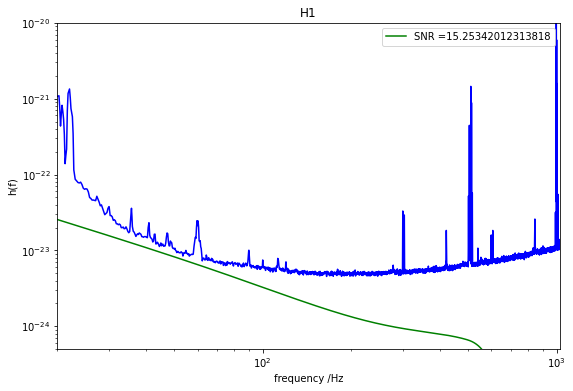

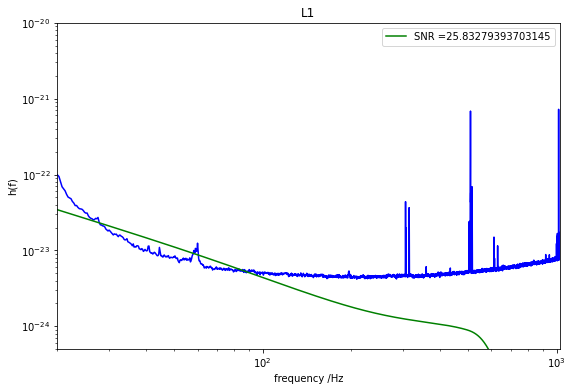

In [5]:
#set injection parameters
SNR=30 #choose signal SNR
distance_given_snr = pickle.load( open( "distance_given_snr.p", "rb" ) )
d=distance_given_snr(SNR) #find corresponding luminosity distance

truths=[20.,10.,d, np.pi/4.,1126259446.,0.6,4.5,-0.5]  #injection parameters ('m1','m2','dl','iota','t0','psi','ra','dec')

hfs = gw.model(truths, detectors) #get model & apply detector response & delays

#inject signals into detectors
for det in detectors:
    det.inject_signal_into_noise(hfs[det.name])      
    det.plot_signal() 

#check network snr
network.snr()

In [6]:
# set cosmological distance prior
H_0=67.4
Omega_m=0.315
prior_dl=gw.cosmo_distance_prior(H_0, Omega_m)

In [7]:
#define the logprior
def logprior(theta,theta_min,theta_max):

    M,q,dl,iota,t0, psi, ra, dec  = theta
    m1, m2 = gw.q_M_to_m1m2(q,M)
    if gw.flatlogprior([m1,m2,dl,iota,t0,psi,ra,dec],theta_min,theta_max) == -np.inf:
        return -np.inf
    else:
        p1=gw.prior_q_M(q,M)
        p2=prior_dl(dl)
        p3=gw.prior_dec(dec)
        p4=gw.prior_iota(iota)
        
        if p1==0 or p2==0 or p3==0 or p4==0:
            return -np.inf     # if outside the bounds return probability = 0 (log-prob = -infinity)
        else: 
            return np.log(p1*p2*p3*p4)

In [13]:
#define the logposterior (phase marginalised)
def logprob(theta,theta_min, theta_max, T):

    M,q,dl,iota,t0, psi, ra, dec = theta

    logp = logprior(theta,theta_min,theta_max)
    
    if logp == -np.inf:
        return logp
    else:
        m1,m2 = gw.q_M_to_m1m2(q,M)
        model = gw.model([m1,m2,dl,iota,t0,psi,ra,dec], detectors)
        likelihood = network.network_phase_marg_loglikelihood(model)
        return (1/T)*likelihood + logp

In [8]:
#define the loglikelihood (phase marginalised)
def logL(theta):
    M,q,dl,iota,t0, psi, ra, dec = theta
    m1,m2=gw.q_M_to_m1m2(q,M)
    
    model = gw.model([m1,m2,dl,iota,t0,psi,ra,dec], detectors)
    
    return network.network_phase_marg_loglikelihood(model)

In [10]:
#intialise the prior bounds, sample starting location, sampling parameters

M=gw.chirp_mass(20.,10.)
q=gw.q(20.,10.)

theta = [M,q,d,np.pi/4.,1126259446.,0.6,4.5,-0.5] #theta_start ('M','q','dl','iota','t0','psi','ra','dec')
theta_min=np.array([15.,6.,0.,0.,1126259446.-0.05,0.,0.,-np.pi/2])
theta_max=np.array([25.,15.,5000.,np.pi/2.,1126259446.+0.05,np.pi,2*np.pi,np.pi/2])
Q = [0.0001,0.001,200.,0.01,0.0001,0.01,0.01,0.01]  # the initial diagonal covariance matrix for the proposal distribution 

Mstart = gw.chirp_mass(18.,8.)
theta_start = [Mstart,18/8,2000.,0.5,1126259446.+0.02,0.,0.,0.]     # the start location in the parameter space

temps=np.logspace(0,3,8)  #temperatures

In [11]:
import ptmcmc

In [14]:
%%time
n=1000000  #total number of posterior samples
nswap=100   #propose swaps between tempered chains every n samples

#run posterior sampling with the Adaptive PTMCMC
samples, infodict = ptmcmc.parallel_tempering(logprob, logL, n, nswap, temps, Q, theta_min, theta_max, theta_start, swap=True, adapt=True, infs=True)

CPU times: user 5.01 s, sys: 19.1 ms, total: 5.03 s
Wall time: 5.12 s


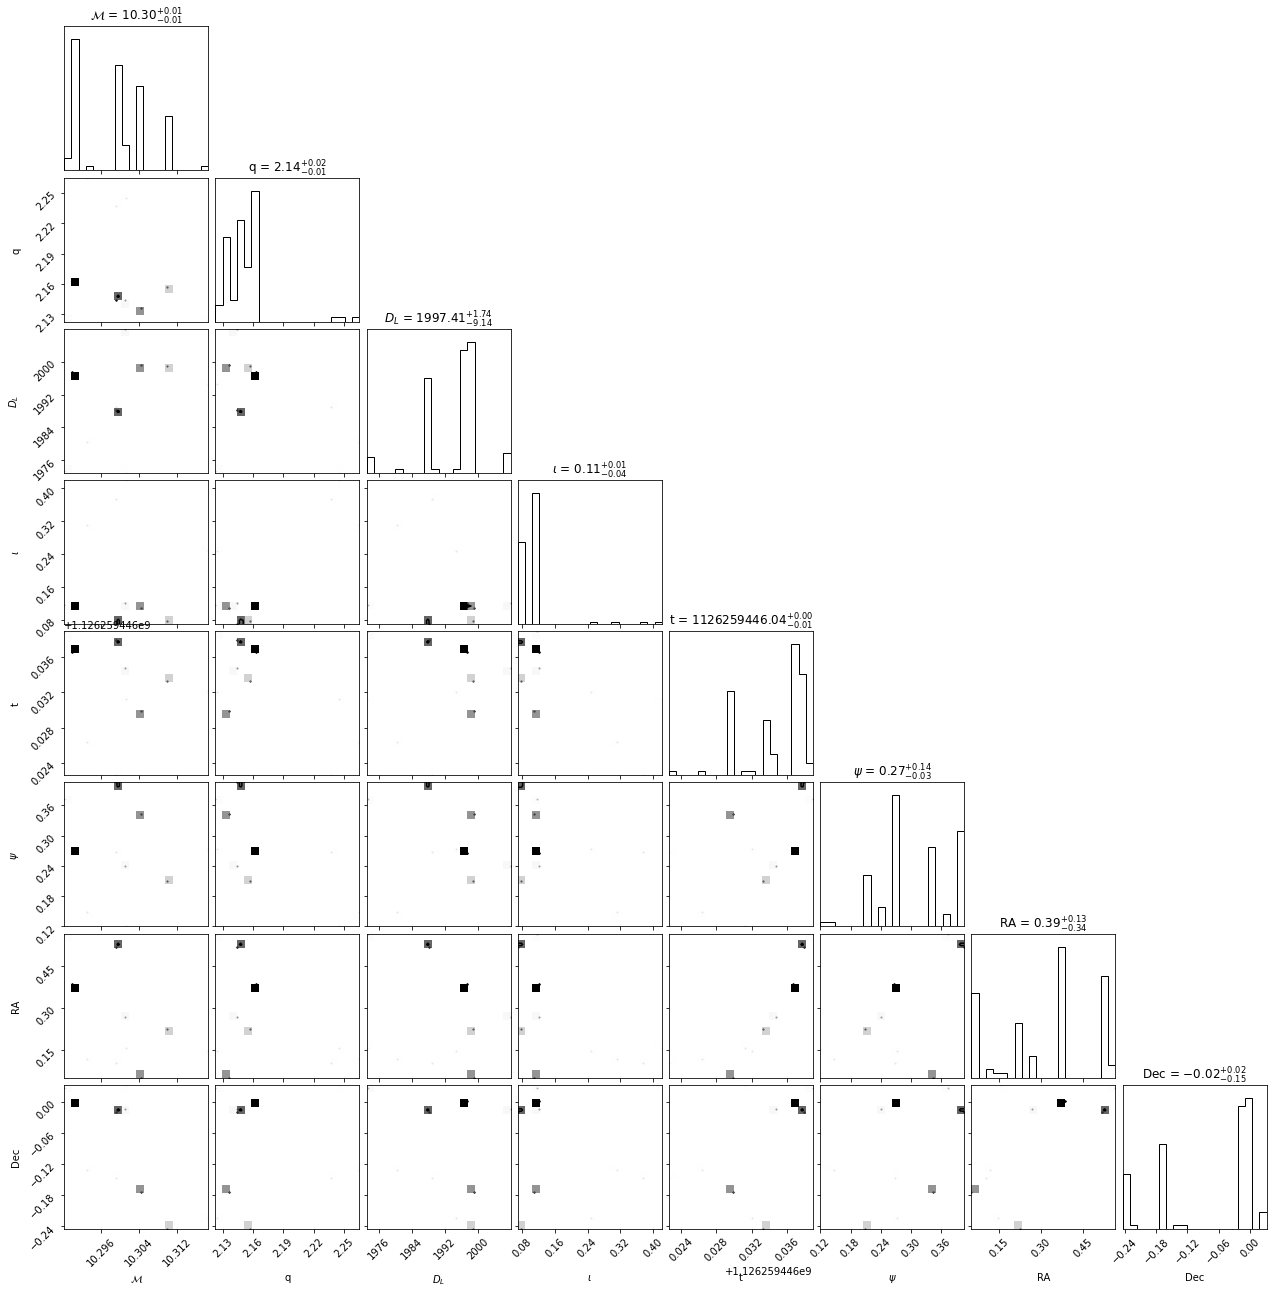

In [15]:
#plot corner plot
figure = corner.corner(samples[1][:],range=(1,1,1,1,1,1,1,1),labels=[r"$ \mathcal{M}$", r"q", r"$D_L$", r"$\iota$",r"t",r"$\psi$",r"RA",r"Dec"],
                       truths=theta, 
                       show_titles=True, title_kwargs={"fontsize": 12})       